<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems


# All pairs of shortest paths


## Contents

In this notebook, we will learn

- How to parallelize Floyd's algorithm
- How communication can affect the correctness of a distributed algorithm


<div class="alert alert-block alert-info">
<b>Note:</b> Do not forget to run the next cell before starting studying this notebook. 
</div>

In [17]:
using Printf

function answer_checker(answer,solution)
    if answer == solution
        "🥳 Well done!"
    else
        "It's not correct. Keep trying! 💪"
    end |> println
end
floyd_check(answer) = answer_checker(answer,"c")
floyd_impl_check(answer) = answer_checker(answer, "d")
function q1_answer(bool)
    bool || return
    msg = """
    It is not needed to start the loop over `j` with `j=k` as none of the entries of the matrix will be updated
    in this particular case. Rememebr: `C[i,j] = min(C[i,j],C[i,k]+C[k,j])` if we substitute `j=k`, we get:
    `C[i,k] = min(C[i,k],C[i,k]+C[k,k])`. Rememeber that `C[k,k]=0, thus, `C[i,k] = min(C[i,k],C[i,k])`, or
    `C[i,k] = C[i,k]`. In other words, the new value of `C[i,k]` will correspond to the old value.
    The same is true for `i=k`.
    """
    println(msg)
end
println("🥳 Well done!")

🥳 Well done!


## The All Pairs of Shortest Paths (ASP) problem

In this notebook, we will parallelize the [Floyd–Warshall algorithm](https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm) used to find a solution of the  all pairs of shortest paths (ASP) problem.

### Problem statement

- Given a graph $G$ with a distance table $C$
- Compute the length of the shortest path between any two nodes in 
$G$

We represent the distance table as a matrix $C$, where $C_{ij}$ is the distance from node $i$ to node $j$ via a direct connection (a single hop in the graph). If there is no direct connection from $i$ to $j$, this is represented using a very large value in $C_{ij}$ (e.g. the largest possible floating point number, `inf`). 
The next figure shows a simple directed graph with 4 nodes an its corresponding distance matrix (matrix labeled as "input").

<div>
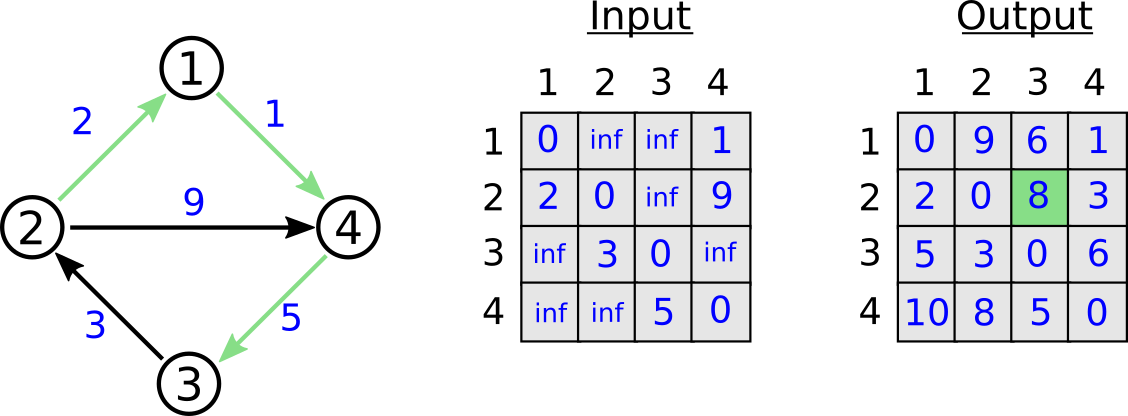
</div>
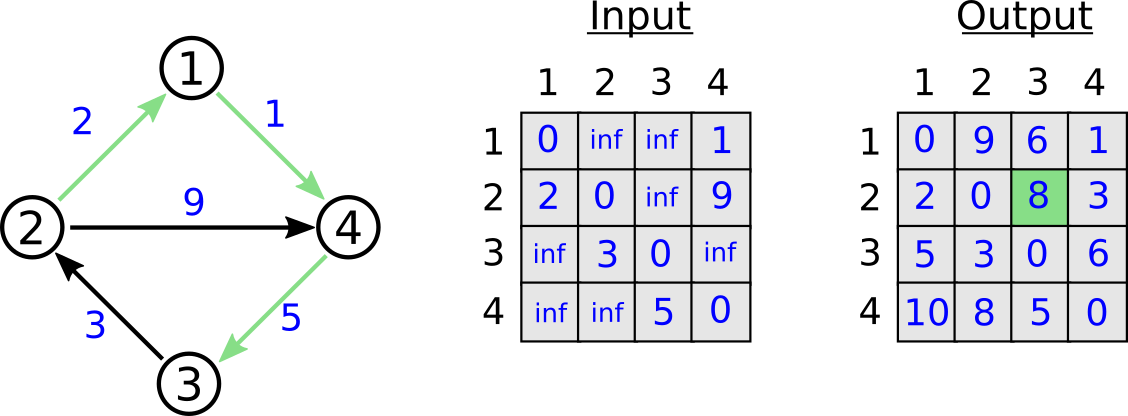

The ASP problem consists in computing the minimum distance between any two pair of nodes $i$ and $j$ in the graph. All these values can be also represented as a matrix (matrix labeled as "output" in the figure above). For instance, the minimum distance from node 2 to node 3 is 8 as highlighted in the figure.

### Floyd's sequential algoritm

The ASP problem can be solved with the  [Floyd–Warshall algorithm](https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm). A sequential implementation of this algorithm is given in the following function:

In [4]:
function floyd!(C)
  n = size(C,1)
  @assert size(C,2) == n
  for k in 1:n
    for j in 1:n
      for i in 1:n
        @inbounds C[i,j] = min(C[i,j],C[i,k]+C[k,j])
      end
    end
  end
  C
end

floyd! (generic function with 1 method)

You can check that this function computes the solution of the small ASP problem in the figure above by executing next cell.

In [6]:
inf = 1000
C = [
      0 inf inf   1
      2   0 inf   9
    inf   3   0 inf
    inf inf   5   0   
]
floyd!(C)

4×4 Matrix{Int64}:
  0  9  6  1
  2  0  8  3
  5  3  0  6
 10  8  5  0

<div>
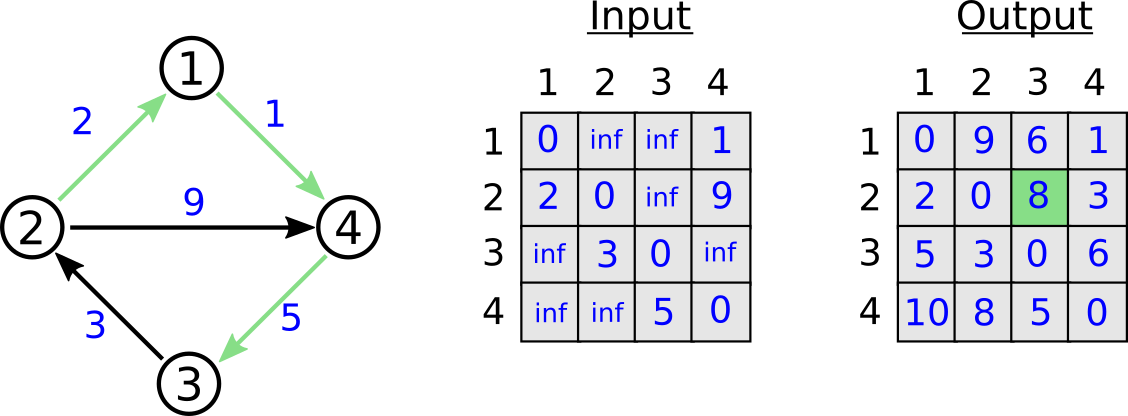
</div>
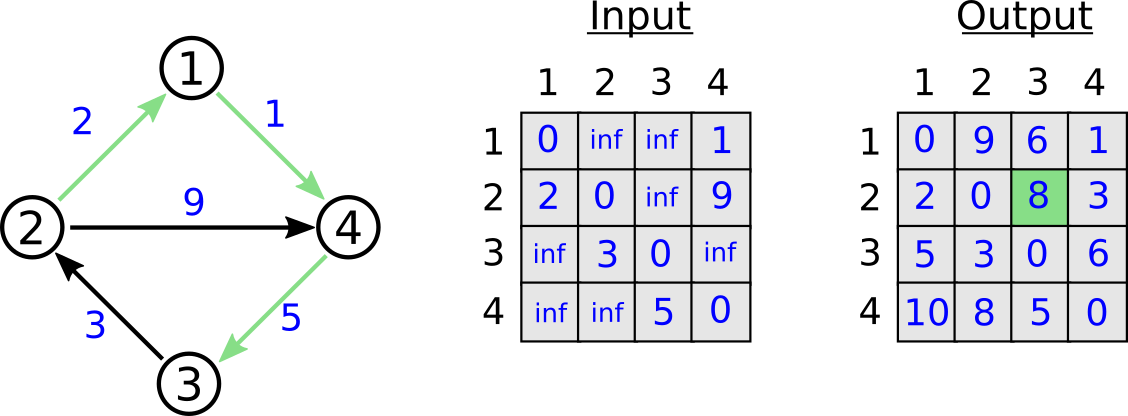

### The algorithm explained

The main idea of the algorithm is to perform as many iterations as nodes in the graph. At iteration $k$, we update the distance matrix $C$ by finding the shortest paths between each pair of nodes, allowing indirect paths via nodes from 1 to $k$. At the last iteration, it is allowed to visit all nodes and, thus, the distance table will contain the minimum possible distances, i.e. the solution of the ASP problem.

This process is cleverly done with three nested loops:

```julia
n = size(C,1)
for k in 1:n
    for j in 1:n
        for i in 1:n
            C[i,j] = min(C[i,j],C[i,k]+C[k,j])
        end
    end
end
```

At each outer iteration $k$, we do a loop over the distance matrix $C$. For each pair of nodes  $i$ and $j$ we compare the current distance $C_{ij}$ against the distance via node $k$, namely $C_{ik}+C_{kj}$, and update  $C_{ij}$ with the minimum.

<div>
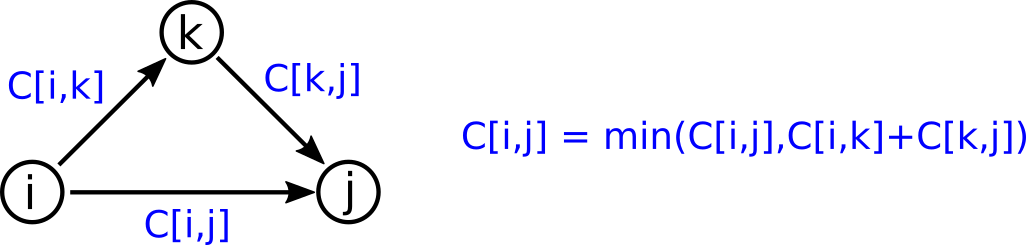
</div>

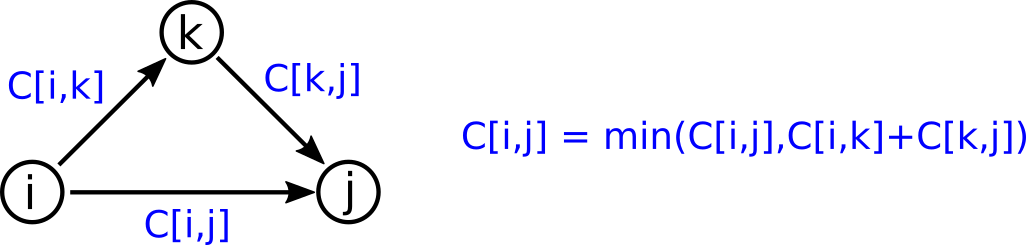

The update of the distance matrix at each iteration is illustrated in the next figure for a small ASP presented above. We highlight in green the distances that are updated in each iteration.


<div>
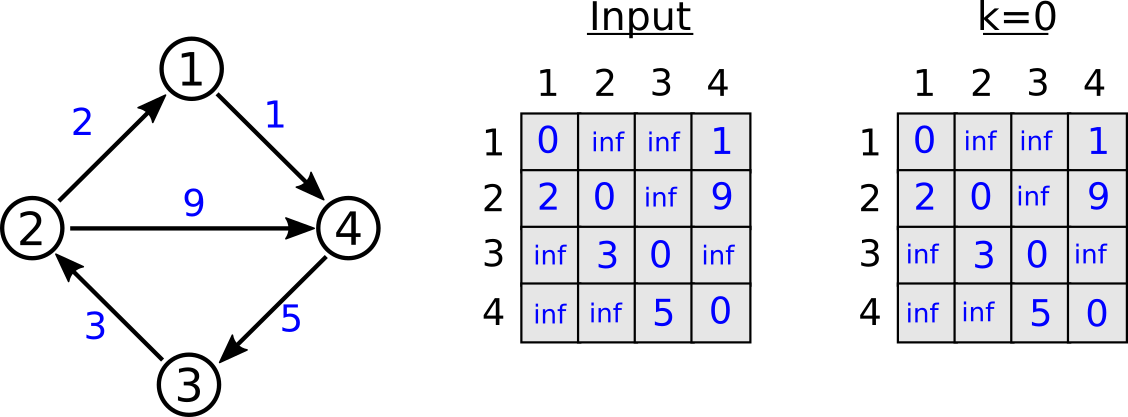
</div>
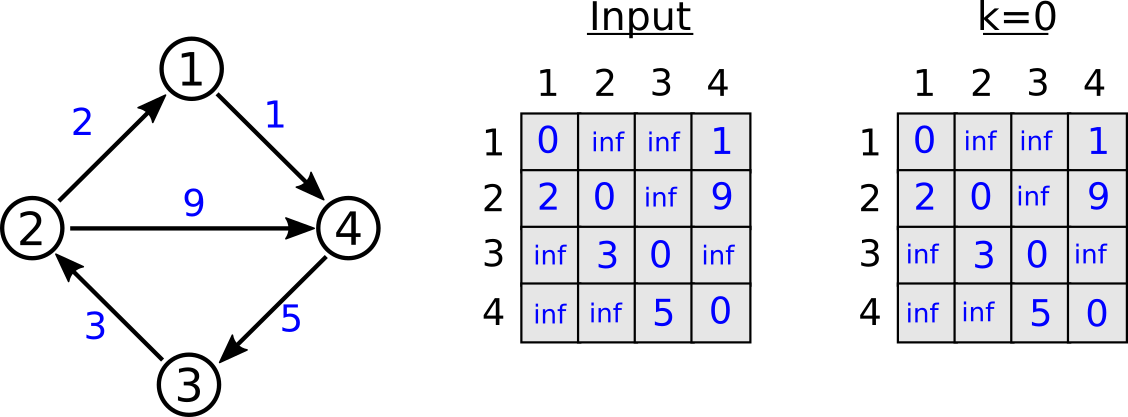

<div>
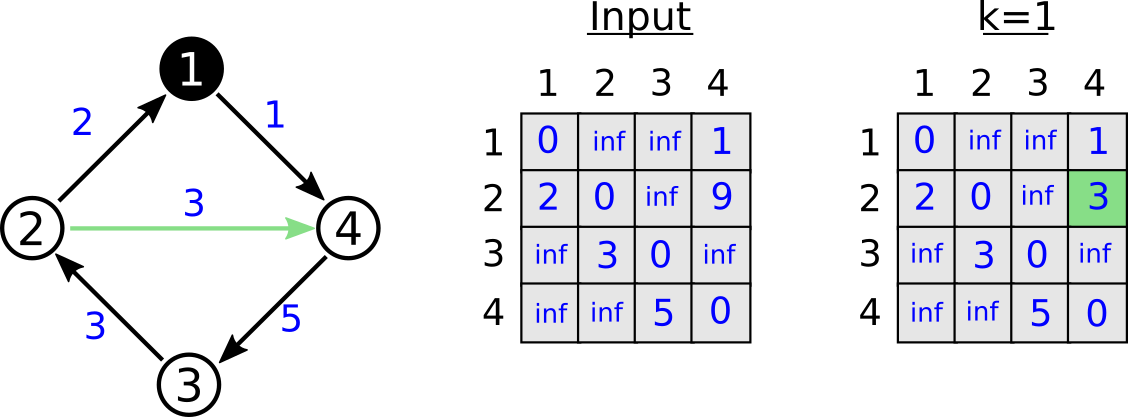
</div>
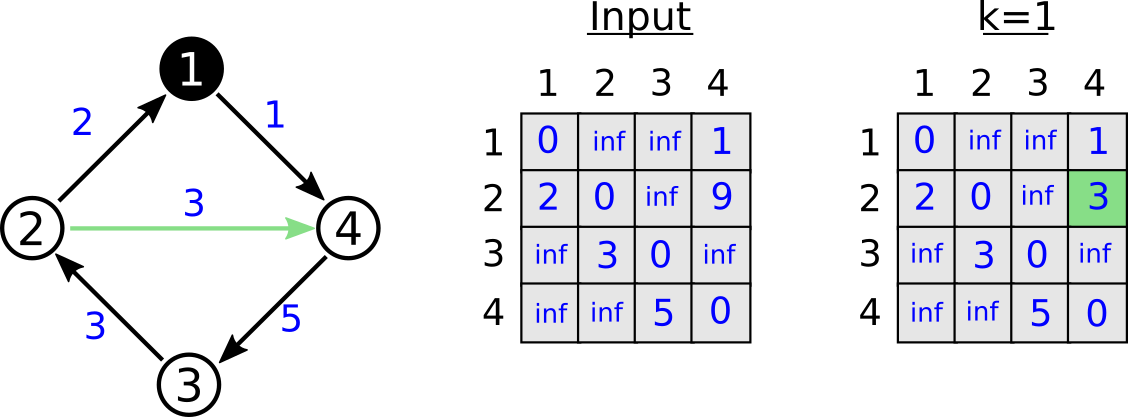

<div>
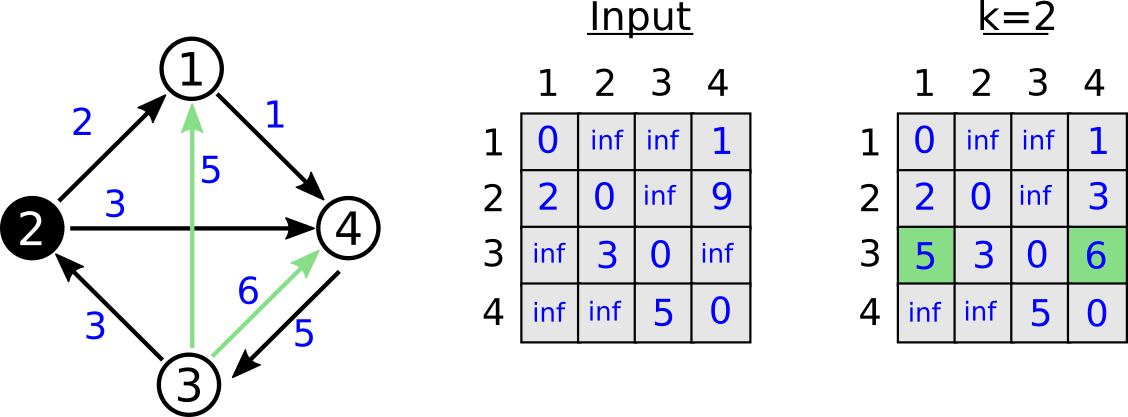
</div>
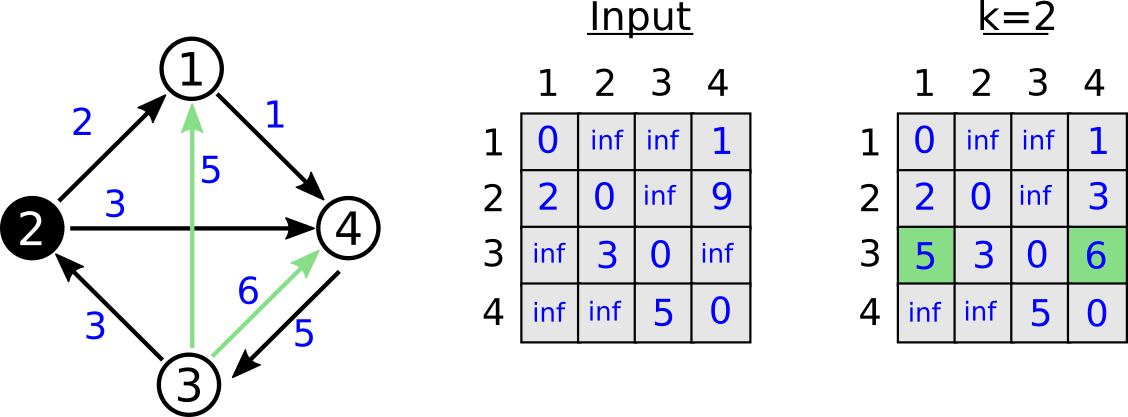

<div>
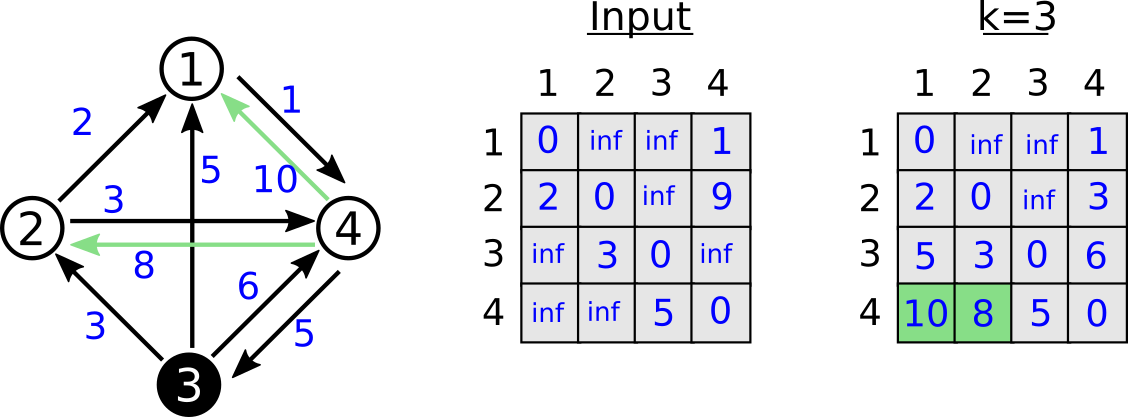
</div>
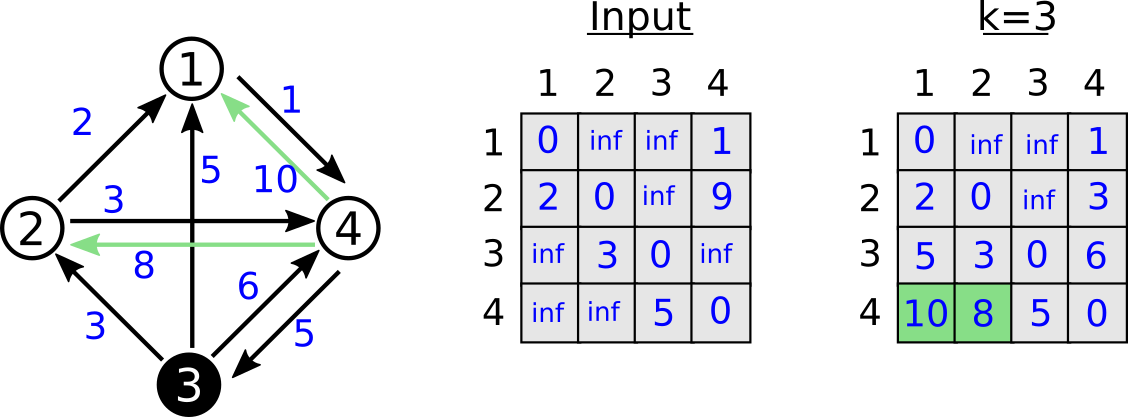

<div>
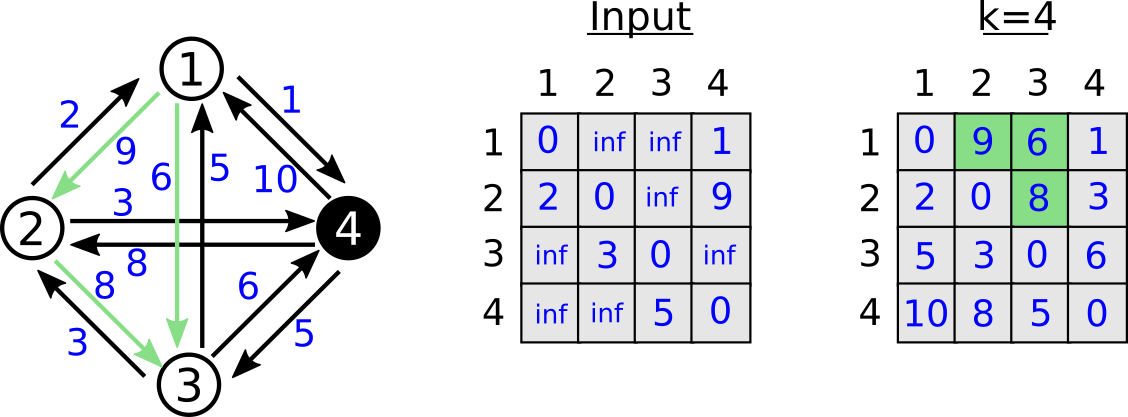
</div>
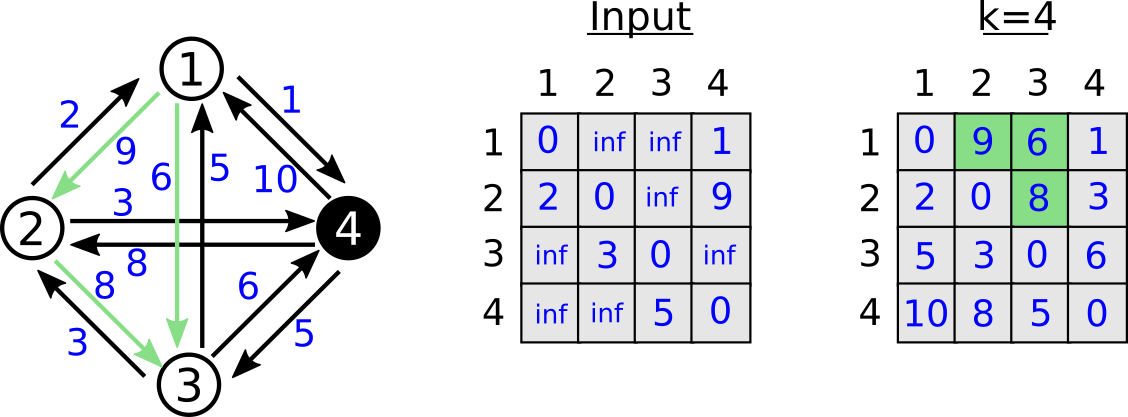

### Serial performance

This algorithm is memory bound, meaning that the main cost is in getting and setting data from the input matrix `C`. In this situation, the order in which we traverse the entries of matrix `C` has a significant performance impact.

The following function computes the same result as for the previous function `floyd!`, but the nesting of loops over i and j is changed.


In [8]:
function floyd2!(C)
  n = size(C,1)
  @assert size(C,2) == n
  for k in 1:n
    for i in 1:n
      for j in 1:n
        @inbounds C[i,j] = min(C[i,j],C[i,k]+C[k,j])
      end
    end
  end
  C
end

floyd2! (generic function with 1 method)

 Compare the performance of both implementations (run the cell several times).

In [10]:
n = 1000
C = rand(n,n)
@time floyd!(C)
C = rand(n,n)
@time floyd2!(C);

  1.777208 seconds
  2.967238 seconds


The performance difference is significant. Matrices in Julia are stored in memory in column-major order (like in Fortran, unlike in C and Python). It means that it is more efficient to access the data also in column-major order (like in function `floyd!`). See this section of [Julia's performance tips](https://docs.julialang.org/en/v1/manual/performance-tips/#man-performance-column-major) if you are interested in further details.

## Parallelization

Now, let us move to the parallelization of the method.

### Where can we exploit parallelism?

Recall:

```julia
n = size(C,1)
for k in 1:n
    for j in 1:n
        for i in 1:n
            C[i,j] = min(C[i,j],C[i,k]+C[k,j])
        end
    end
end
```

- The outer loop cannot be parallelized since the operations at iteration $k$ require the result of iteration $k-1$.
- The inner loops over $i$ and $j$ can be parallelized at a given iteration $k$.


<div class="alert alert-block alert-success">
<b>Question (hard):</b>  Can we really parallelize the loops over `i` and `j` ? To compute `C[i,j]` at iteration `k`, we first need to compute `C[i,k]` and `C[k,j]`. In order words, it seems that the order of the loops over `i` and `j` cannot be arbitrary. The first value of `i` and `j` in the loops should be `k`. However,  this is not really necessary, why?
</div>

In [18]:
uncover = true
q1_answer(uncover)

It is not needed to start the loop over `j` with `j=k` as none of the entries of the matrix will be updated
in this particular case. Rememebr: `C[i,j] = min(C[i,j],C[i,k]+C[k,j])` if we substitute `j=k`, we get:
`C[i,k] = min(C[i,k],C[i,k]+C[k,k])`. Rememeber that `C[k,k]=0, thus, `C[i,k] = min(C[i,k],C[i,k])`, or
`C[i,k] = C[i,k]`. In other words, the new value of `C[i,k]` will correspond to the old value.
The same is true for `i=k`.



### Parallelization strategy

As for the matrix-matrix product and Jacobi, any of the iterations over $i$ and $j$ are independent and could be computed on a different processor. However, we need a larger grain size for performance reason. Here, we adopt the same strategy as for algorithm 3 in the matrix-matrix product:

- Each process will update a subset of consecutive rows of the distance table $C$ at each iteration $k$.

<div>
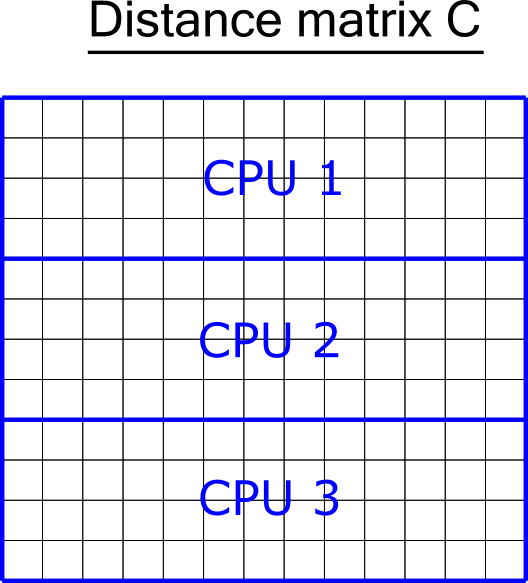
</div>
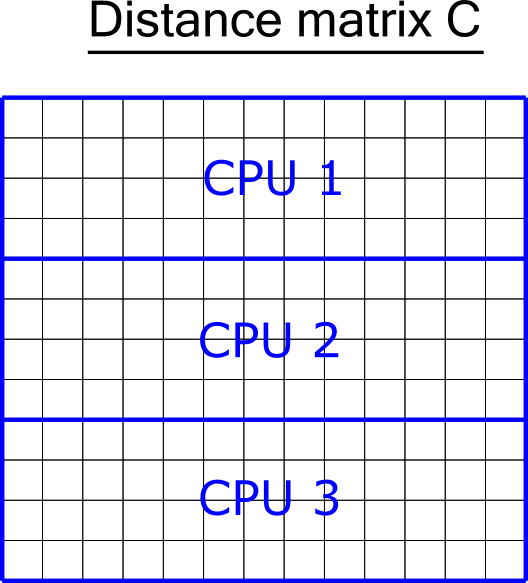

### Data dependencies

Recall: we perform this update at iteration $k$:

`C[i,j] = min(C[i,j],C[i,k]+C[k,j])`

If each process updates a block of rows of matrix $C$, which data do we need for this operation?


<div>
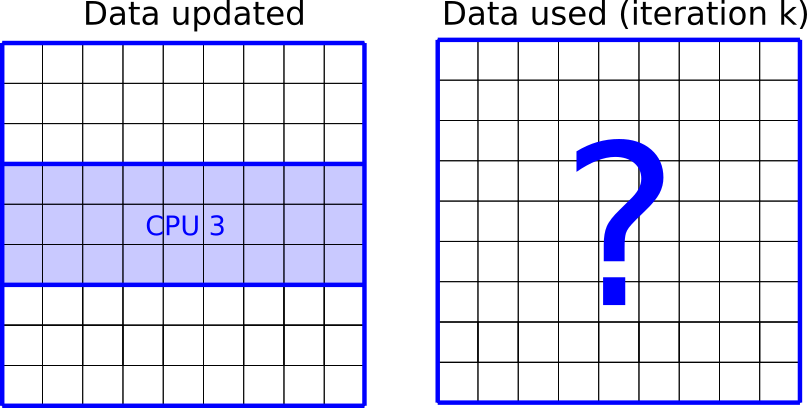
</div>
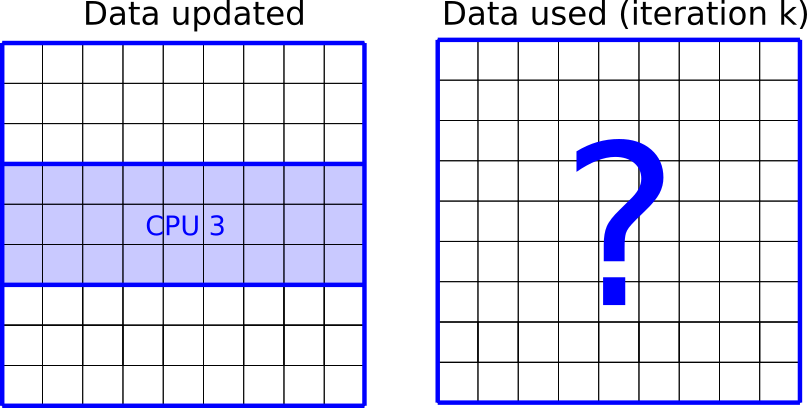

At each iteration, the processor needs the input values `C[i,j]`, `C[i,k]` and `C[k,j]`. Since we split the data row-wise, the process already has values `C[i,j]` and `C[i,k]`. However, `C[k,j]` may be stored in a different process. See figure below.

<div>
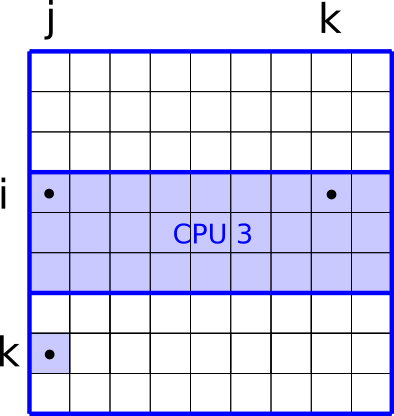
</div>
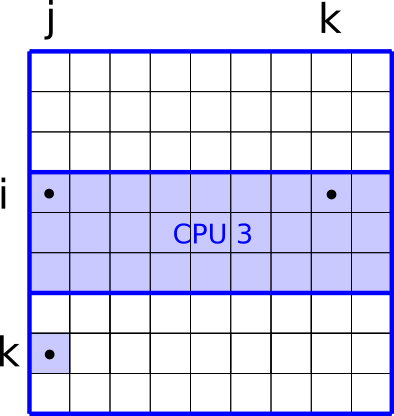

As we iterate over columns $j$, the process needs input from all values of row $k$. Therefore, at the start of iteration $k$, the whole row $k$ needs to be communicated.

<div>
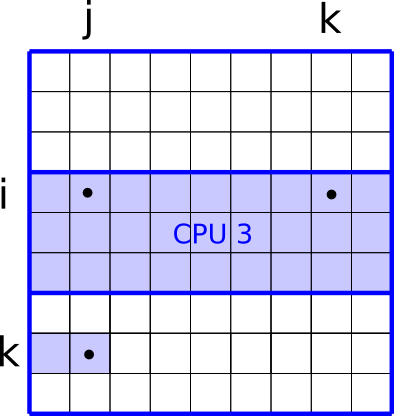
</div>
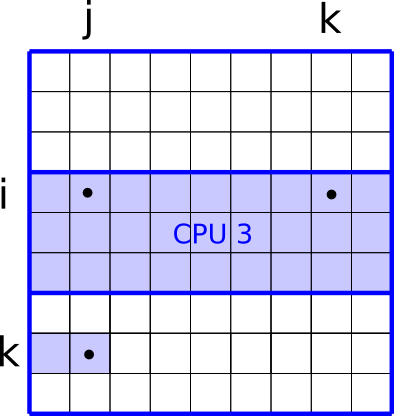

In summary, at iteration $k$ a given process will need row number $k$ which might be stored remotely in another process. The owner of row $k$ needs to *broadcast* this row to the other processes at iteration $k$.

<div>
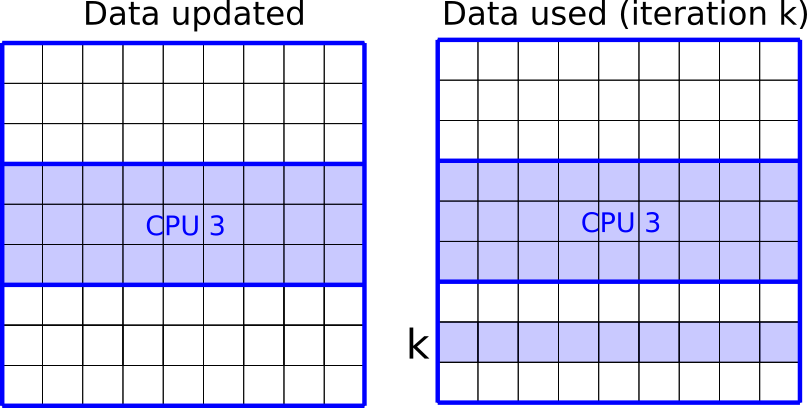
</div>
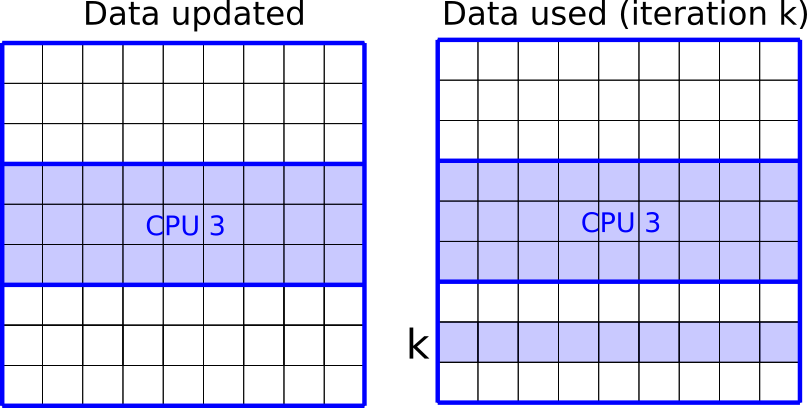

<div class="alert alert-block alert-success">
<b>Question:</b>  How much data is communicated in each iteration in this parallel algorithm?
</div>

    a) O(N²/P)
    b) O(N)
    c) O(NP)
    d) O(P)

In [25]:
answer = "x" # replace x with a, b, c or d
floyd_check(answer)

It's not correct. Keep trying! 💪


### Theoretical performance analysis

### Computation complexity

Each process updates $N^2/P$ entries per iteration. The computation complexity is $O(N^2/P)$.

<div>
    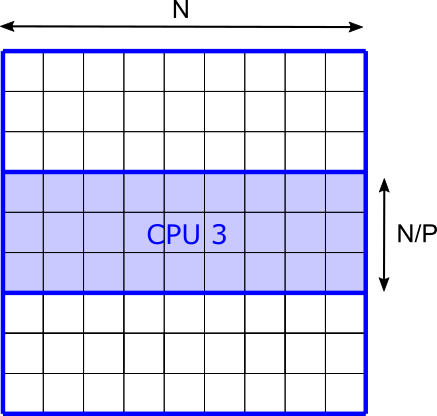
    </div>
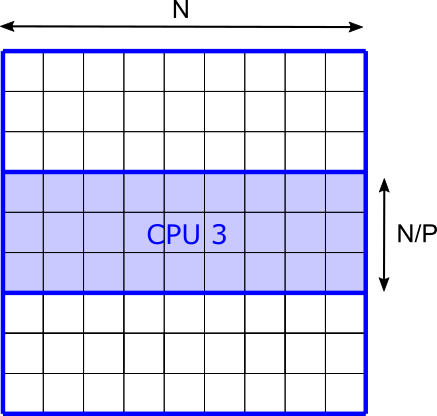

### Communication complexity

- One process broadcasts a message of length $N$ to $P-1$ processes per iteration. Thus, the **send cost** is $O(N P)$ per iteration.
- $P-1$ processes receive one message of length $N$ per iteration. Hence, the **receive cost** is $O(N)$ per iteration at each process. 

<div>
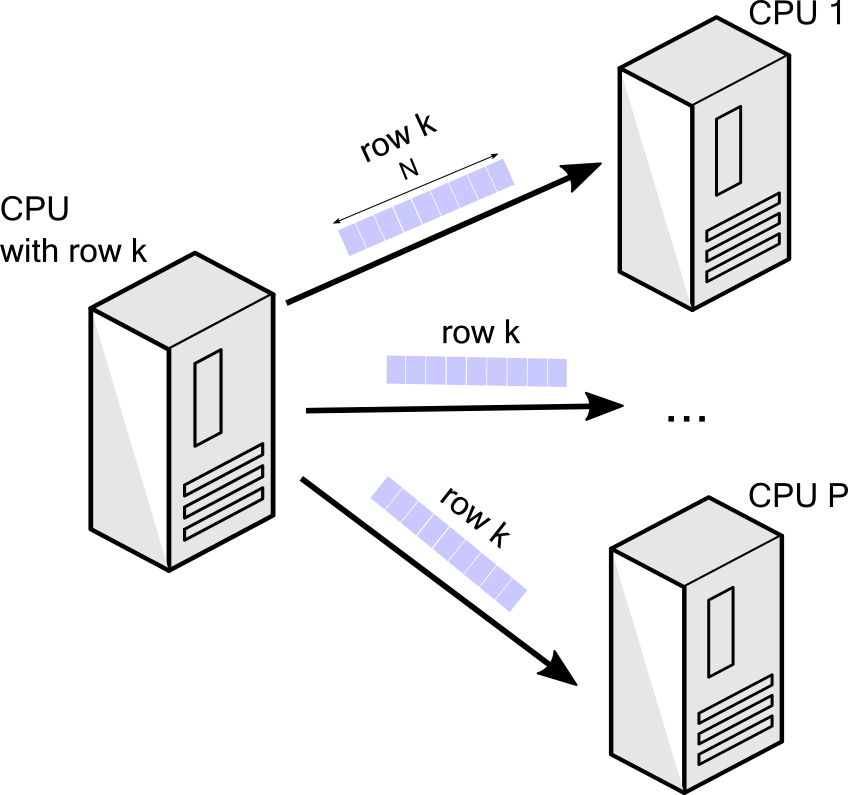
</div>
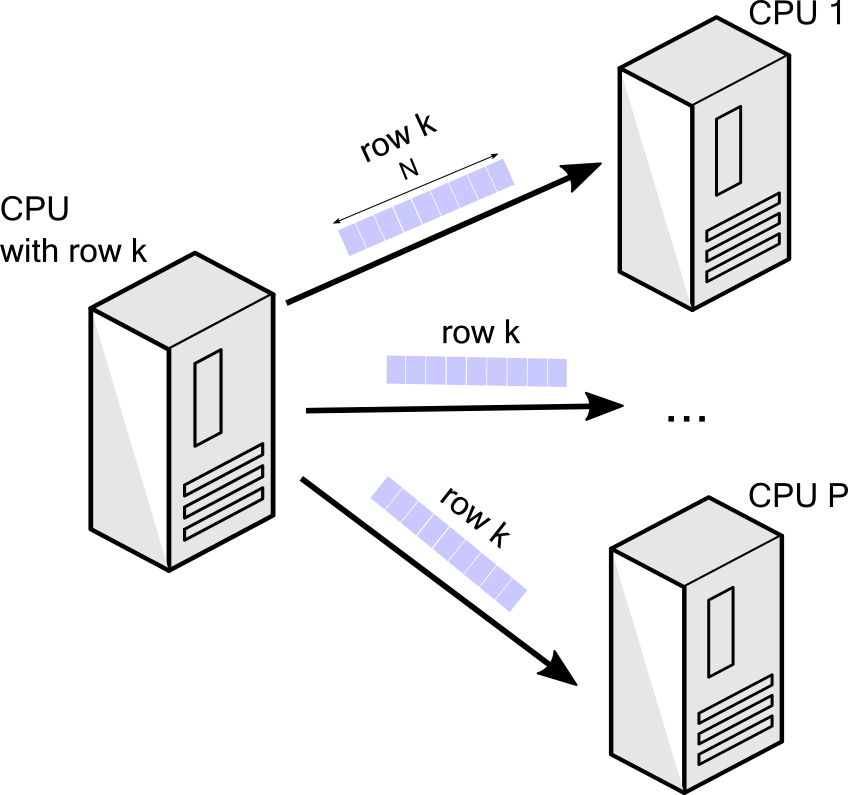

The communication over computation cost is

- On the send side: $O(NP)/O(N^2/P) = O(P^2/N)$
- On the receive side $O(N)/O(N^2/P) = O(P/N)$


In summary, the send/computation ratio is $O(P^2/N)$ and the receive/computation ratio is $O(P/N)$. The algorithm is potentially scalable if $P^2<<N$.

## Parallel Implementation

Now, we will explore the parallel implementation of Floyd's algorithm. We will use MPI.

In [ ]:
] add MPI

In [ ]:
using MPI

### Code

We split the code into two functions. The first function is called on the main process (the process running this notebook). It splits the input matrix into blocks of rows. Then, we use a remotecall to compute Floyd's algorithm in each worker with its corresponding block of rows.


In [ ]:
function floyd_dist!(C)
    m = size(C,1)
    @assert mod(m,nworkers()) == 0
    nrows_w = div(m,nworkers())
    @sync for (i,w) in enumerate(workers())
        rows_w = (1:nrows_w) .+ (i-1)*nrows_w
        Cw = C[rows_w,:]
        @async C[rows_w,:] = remotecall_fetch(floyd_worker!,w,Cw,rows_w)
    end
    C
end

The second function is the one that runs on the workers. Note that we use MPI for communication in this case.

In [ ]:
@everywhere function floyd_worker!(Cw,rows_w)
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    rank = MPI.Comm_rank(comm)
    nranks = MPI.Comm_size(comm)
    m,n = size(Cw)
    C_k = similar(Cw,n)
    for k in 1:n
        if k in rows_w
            # Send row k to other workers if I have it
            myk = (k-first(rows_w))+1
            C_k .= view(Cw,myk,:)
            for proc in 0:(nranks-1)
                if rank == proc
                    continue
                end
                MPI.Send(C_k,comm;dest=proc,tag=0)
            end
        else
            # Wait until row k is received
            MPI.Recv!(C_k,comm,source=MPI.ANY_SOURCE,tag=0)
        end
        for j in 1:n
            for i in 1:m
                @inbounds Cw[i,j] = min(Cw[i,j],Cw[i,k]+C_k[j])
            end
        end
    end
    Cw
end

<div class="alert alert-block alert-success">
<b>Question:</b>  Which of the following statements is true?
</div>

    a) The processes are synchronized in each iteration due to the blocking send and receive of row k.
    b) Receiving processes may overwrite the data in row k, which can lead to incorrect behavior.
    c) The sending process can only continue the computation after the data are received in every other process.
    d) The receiving process does not know the source of the received data.

In [ ]:
answer = "x" # replace x with a, b, c or d
floyd_impl_check(answer)

### Testing the implementation

In [ ]:
function rand_distance_table(n)
  threshold = 0.4
  mincost = 3
  maxcost = 10
  infinity = 10000*maxcost
  C = fill(infinity,n,n)
  for j in 1:n
    for i in 1:n
      if rand() > threshold
        C[i,j] = rand(mincost:maxcost)
      end
    end
    C[j,j] = 0
  end
  C
end

In [ ]:
using Test
load = 10
n = nworkers()*load
C = rand_distance_table(n)
C_seq = floyd!(copy(C))
C_par = floyd_dist!(copy(C))
@test C_seq == C_par

### Is this implementation correct?

Point-to-point messages are *non-overtaking* (i.e. FIFO order) between the specified sender and receiver according to section 3.5 of the MPI standard 4.0.
Unfortunately this is not enough in this case. The messages can still arrive in the wrong order if messages from different processes overtake each other.

If we are lucky all messages will arrive in order and we will process all rows in the right order in all processors.

<div>
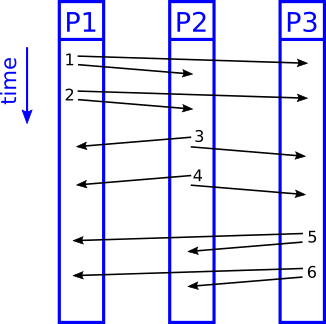
</div>
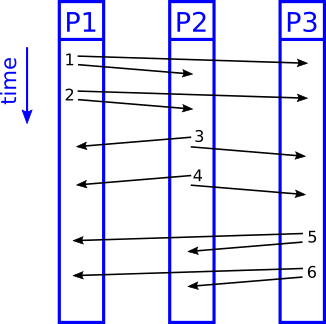

However, FIFO ordering is not enough. In the next figure, communication between process 1 and process 3 is particularly slow. Note that process 3 receives messages from process 1 after it receives the messages from 2 even though FIFO ordering is satisfied between any two processors.

<div>
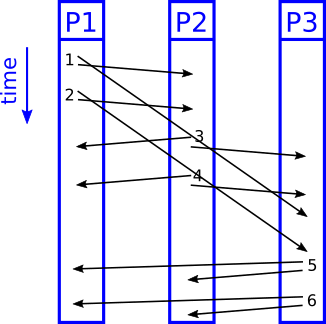
</div>
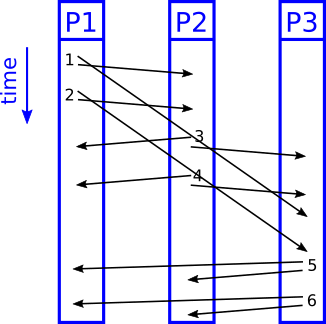

### Possible solutions

1. **Synchronous sends**: Use synchronous send MPI_SSEND. This is less efficient because we spend time waiting until each message is received. Note that the blocking send MPI_SEND used above does not guarantee that the message was received. 
2. **MPI.Barrier**: Use a barrier at the end of each iteration over $k$. This is easy to implement, but we get a  synchronization overhead.
3. **Order incoming messages**: The receiver orders the incoming messages, e.g. according to MPI.Status or the sender rank. This requires buffering and extra user code.
4. **MPI.Bcast!**: Communicate row k using `MPI.Bcast!`. One needs to know which are the rows owned by the other ranks.

## Exercise 
Rewrite the worker code of the parallel ASP algorithm so it runs correctly. Use the `MPI.Bcast!` to solve the problem of overtaking messages. Note: Only use `MPI.Bcast!`, do not use other MPI directives in addition. You can test your function with the following code cell. 

In [ ]:
function floyd_par!(C,N)
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    nranks = MPI.Comm_size(comm)
    rank = MPI.Comm_rank(comm)
    T = eltype(C)
    if rank == 0
        buffer_root = Vector{T}(undef,N*N)
        buffer_root[:] = transpose(C)[:]
    else
        buffer_root = Vector{T}(undef,0)
    end    
    Nw = div(N,nranks)
    buffer =  Vector{T}(undef,Nw*N)
    MPI.Scatter!(buffer_root,buffer,comm;root=0)
    Cw = Matrix{T}(undef,Nw,N)
    transpose(Cw)[:] = buffer
    MPI.Barrier(comm)
    floyd_worker_bcast!(Cw,comm)
    buffer[:] = transpose(Cw)[:]
    MPI.Gather!(buffer,buffer_root,comm;root=0)
    if rank == 0
        transpose(C)[:] = buffer_root[:]
    end
    C
end

@everywhere function floyd_worker_bcast!(Cw,comm)
   # Your implementation here
end


In [ ]:
load = 10
n = nworkers()*load
C = rand_distance_table(n)
C_seq = floyd!(copy(C))
C_par = floyd_par!(copy(C),n)
@test C_seq == C_par

# License



This notebook is part of the course [Programming Large Scale Parallel Systems](https://www.francescverdugo.com/XM_40017) at Vrije Universiteit Amsterdam and may be used under a [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.